## 1. Import libraries

In [38]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 1.1. Helper Functions

In [27]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [39]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 2. Loading Data

In [29]:
df_raw = pd.read_csv( '../data/insurance.csv' )

In [30]:
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


---
# 3. EDA (  Exploration Data Analysis )
---

## 3.1. Descriptive Statistics

In [31]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


## 3.2. Univariate Analysis

## 3.2.1. Response Variable

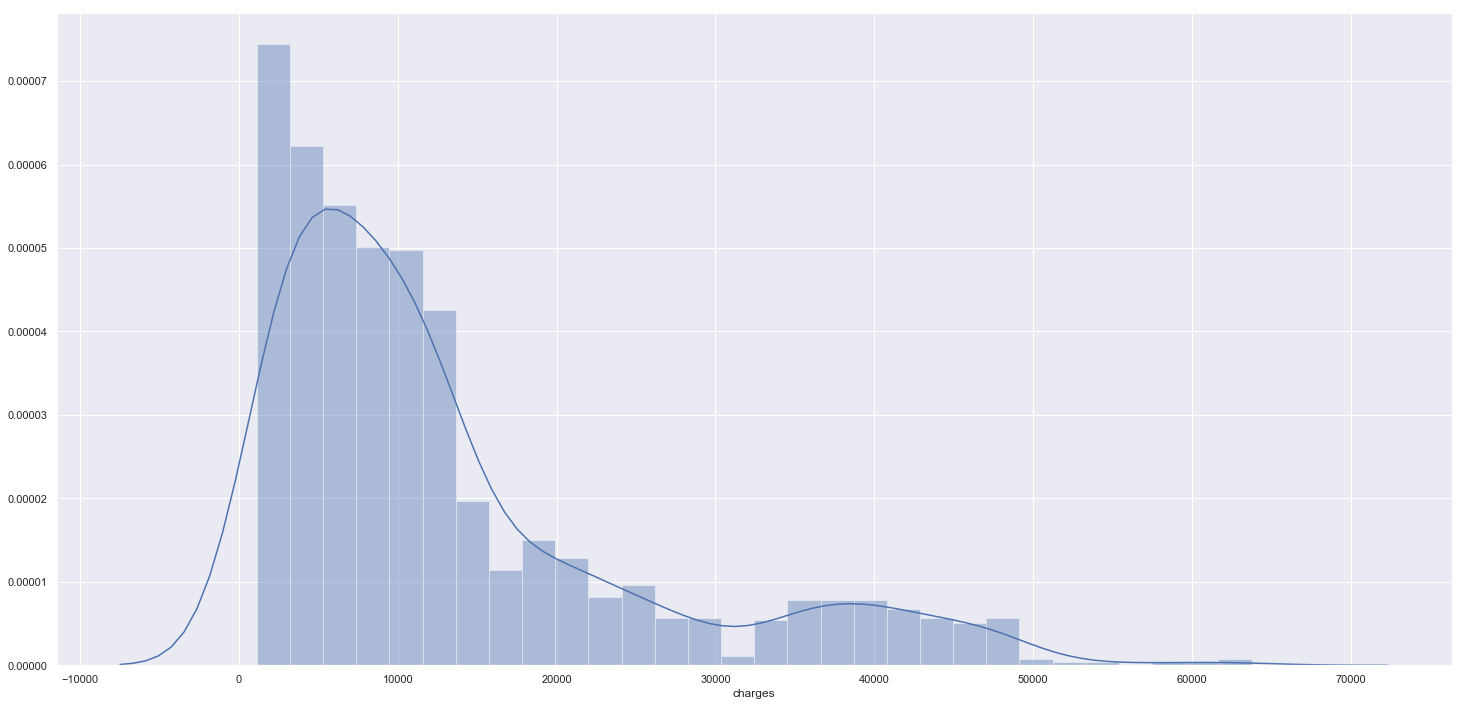

In [81]:
sns.distplot( df_raw['charges'] );

## 3.2.1. Predictors

### AGE

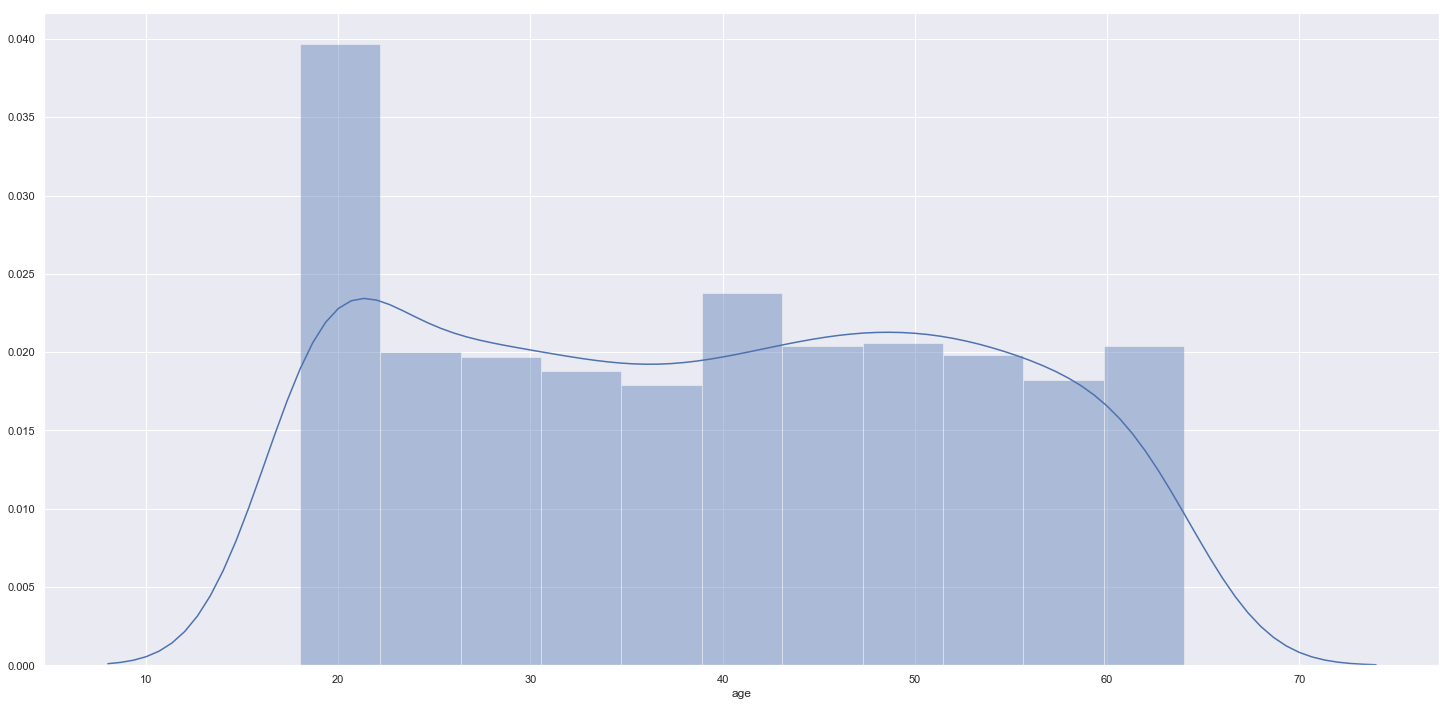

In [79]:
age = sns.distplot( df_raw['age'] )

### BMI

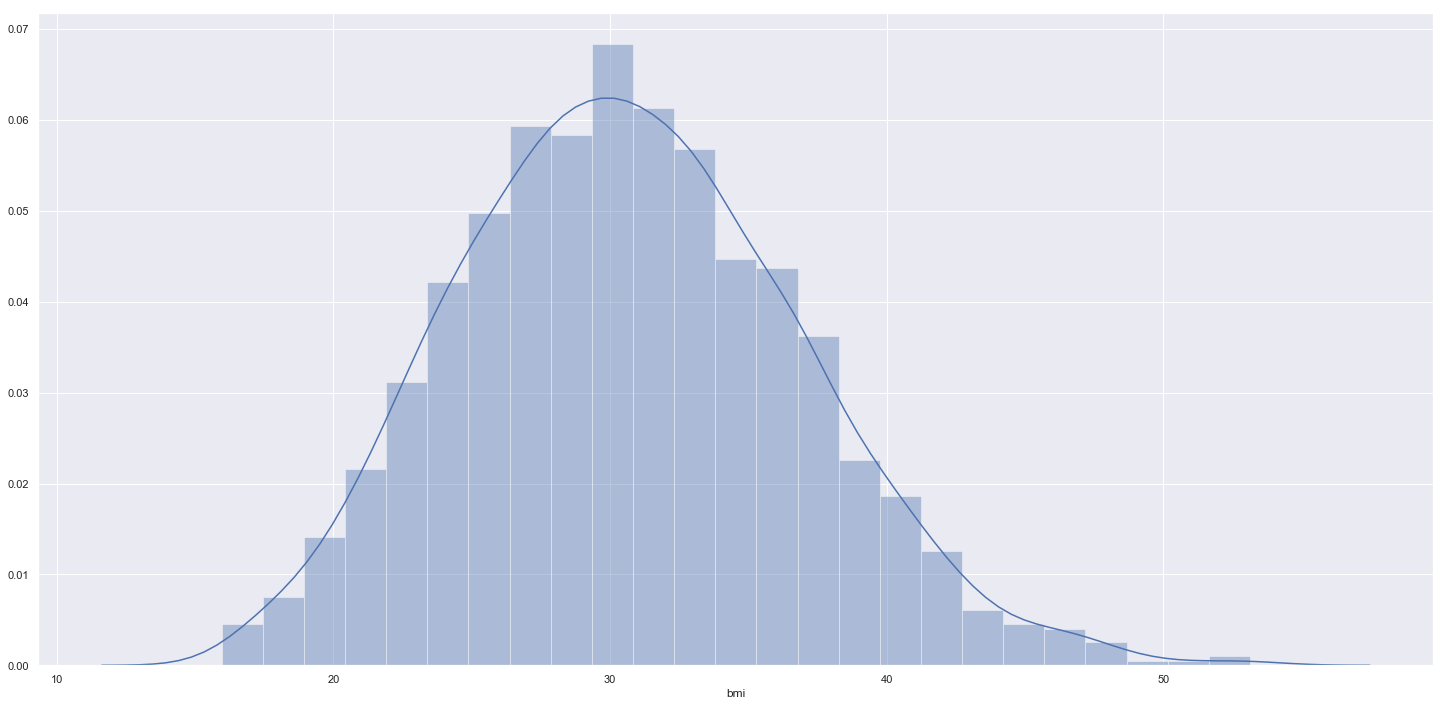

In [80]:
sns.distplot( df_raw['bmi'] )

### CHILDREN

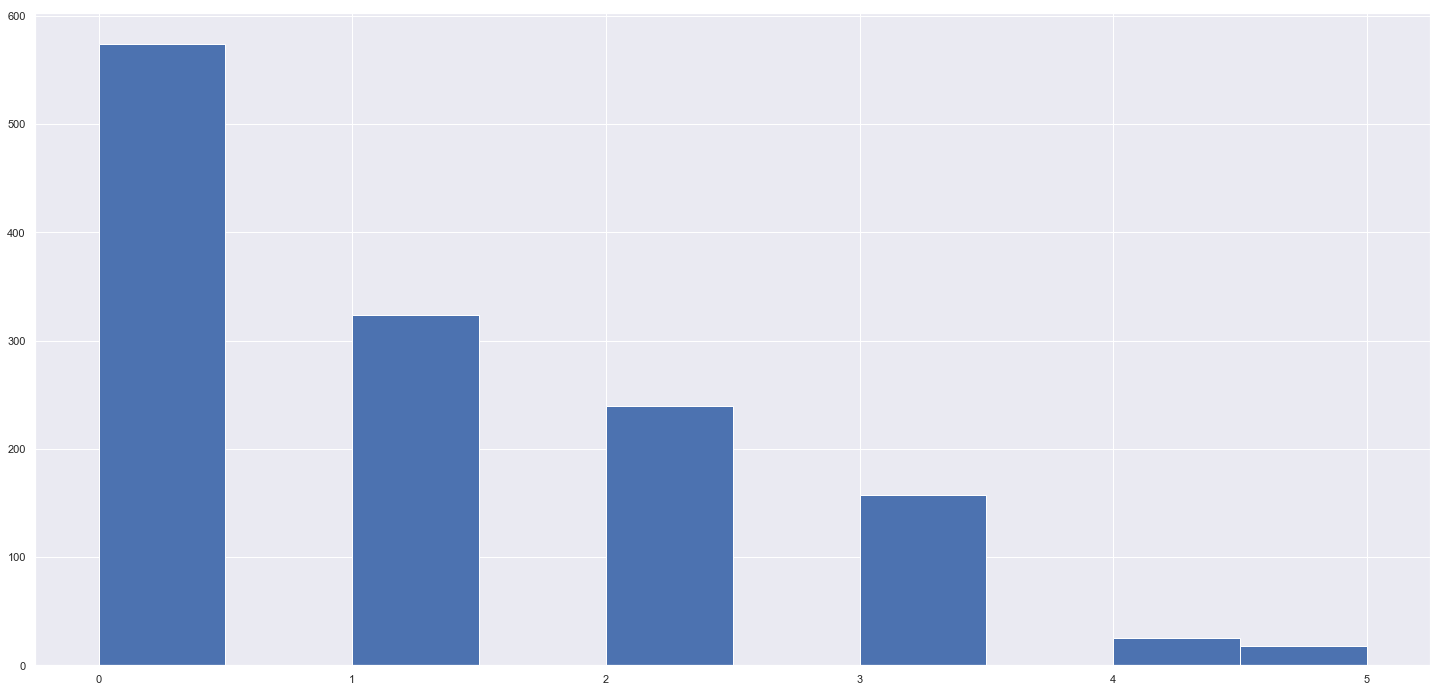

In [87]:
plt.hist( df_raw['children'] );

## 3.3. Bivariate Analysis

### 3.3.1. Numerical Predictors

In [73]:
num_features = df_raw.select_dtypes( include=[np.number] )
num_features.dtypes

# Correlation
corr = num_features.corr()
print( corr['charges'].sort_values( ascending=False ) )

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64


### Age x Charges 

In [71]:
a = df_raw[['age', 'charges']].groupby( 'age' ).sum().reset_index()

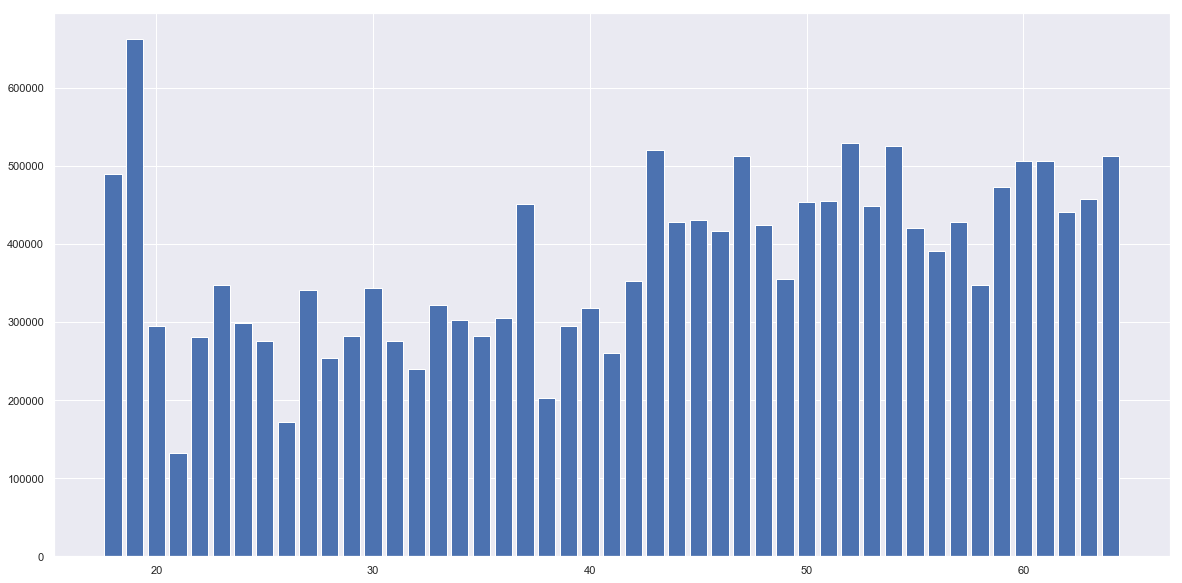

In [72]:
plt.figure( figsize=(20, 10) )
plt.bar( a['age'], a['charges']);

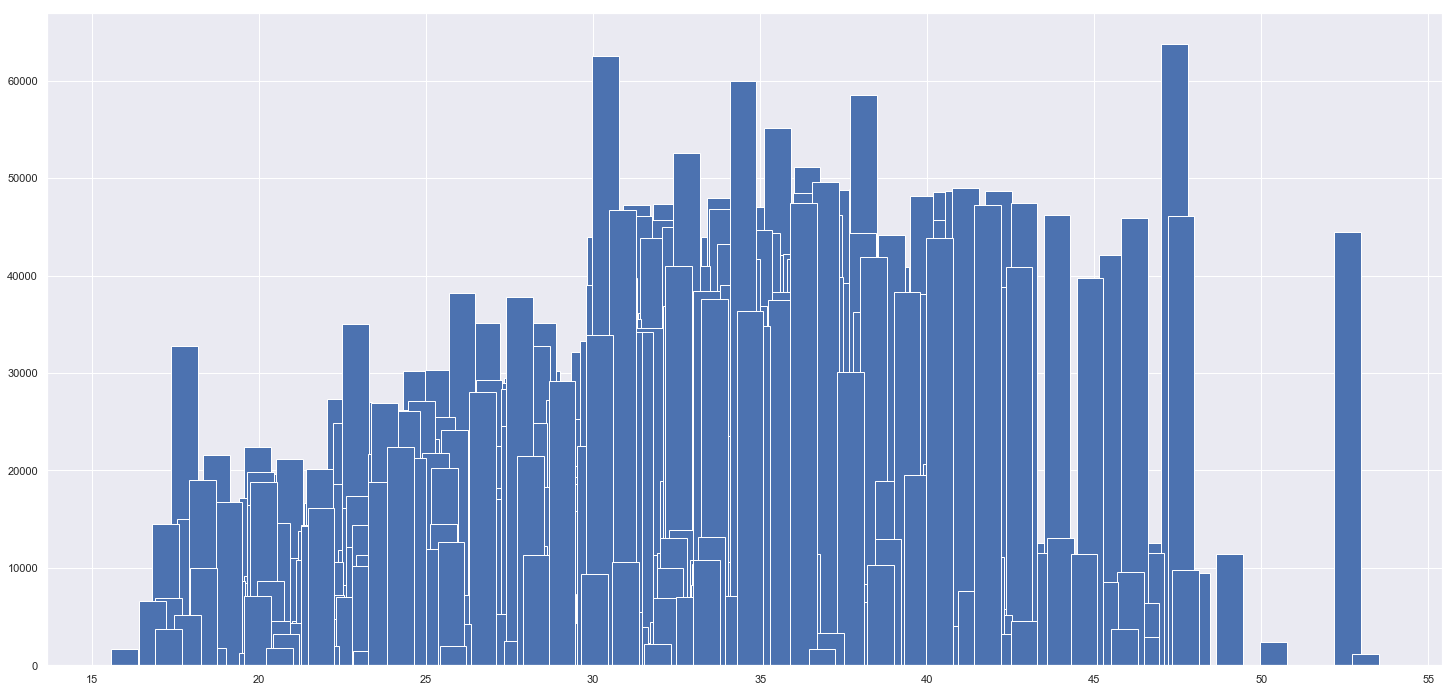

In [76]:
plt.bar( df_raw['bmi'], df_raw['charges'] );

### 3.3.2. Categorical Predictors

## 3.4. Multivariate Analysis

---
# 4. Data Preprocessing  
---

## 4.1. Transformations 

## 4.2. Standardizing and Rescaling 

## 4.3. Binarization and Normalized

---
# 5. Feature Engineering  
---

## 5.1. Create Features

## 5.2. Feature Selection

### 5.2.1. Univariate Selection

### 5.2.2. Recursive Feature Elimination

### 5.2.3. Principal Component Analysis

## 5.3. Split Data into Train and Test Sets

---
# 6. Modelling
---

## 6.1. Training

### 6.1.1. K-Fold Cross-Validation

### 6.1.2. Leave One Out Cross-Validation

## 6.2. Test